# Testing some basic functions for doing Guassian mixture intra-song clustering for identification of "main" beats

If $X_1, \ldots, X_n$ are i.i.d. normal, then the $1 - \alpha$ confidence region is a circle of radius $r$ where
$$P(X_1^2 + \cdots + X_n^2 \leq r^2) =1 - \alpha$$
i.e. given by the square root of the $1-\alpha$ quantile for the chi-squared distribution with $n$ d.f.

A multivariate normal distribution $Y$ with covariance $\Sigma = U S U^t$ is transformed from a standard one $X$ by $Y = AX$ where $A = U S^{1/2}$.  The unit circle is transformed to an ellipse with axes given by the columns of $U$ and axis lengths by $S$.

We default to 95% confidence but I think this might be too strict.

In [19]:
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, bic_winnow_gm_components
from matplotlib.patches import Ellipse
import scipy, math
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test on some generated data sets

Generate a single 2d normal distribution

(1000, 2)


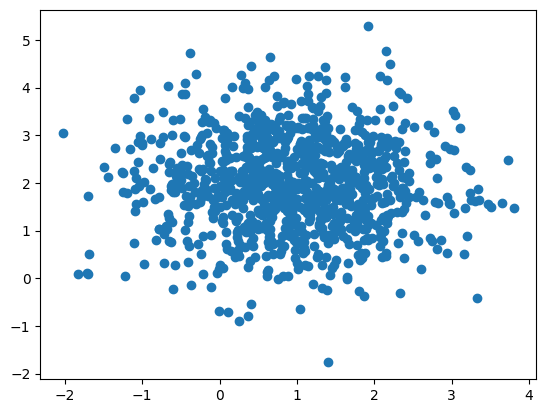

In [20]:
x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)

#x = np.concatenate([x1, x2])
#y = np.concatenate([y1, y2])

x = x1
y = y1

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


[[0.94083341 1.98960666]] [[[ 0.94969621 -0.0096517 ]
  [-0.0096517   0.97082872]]]
Num covered: 0.891, valid covered: 0.891, overlapped: 0.0


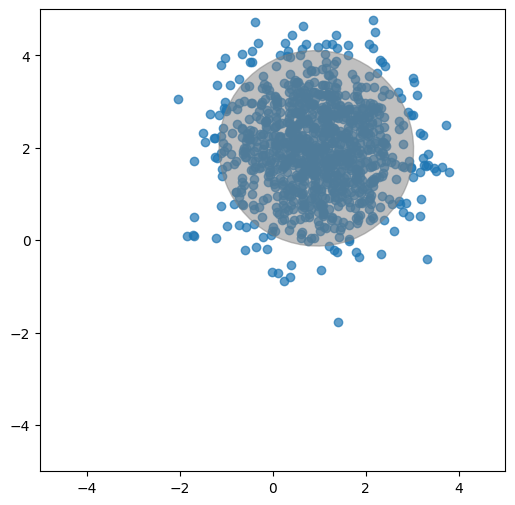

In [21]:
gm = GaussianMixture(n_components=1)


gm.fit(data)

print(gm.means_, gm.covariances_)

#bgm = BayesianGaussianMixture(n_components=2)
#bgm.fit(data)
#print(bgm.means_.shape)

patches, coverage = get_patches(gm, 0.9, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

p = patches[0]

print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")



plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

My conclusion from the below is that the patches "contains points" is buggy as shit.  (Note: comment out the set_axlim to fix at least one bug.)

In [22]:
p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data, confidence=0.90))).sum())

print(data.shape[0])
print(f"patch way: {p.contains_points(data).sum()}")
print(f"my way: {ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()}")


109
1000
patch way: 0
my way: 946


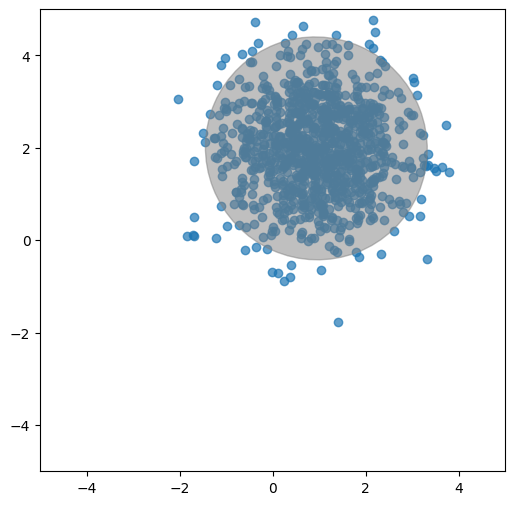

In [23]:
gm = winnow_gm_components(data)
patches, _ = get_patches(gm, 0.95, data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(500, 2)


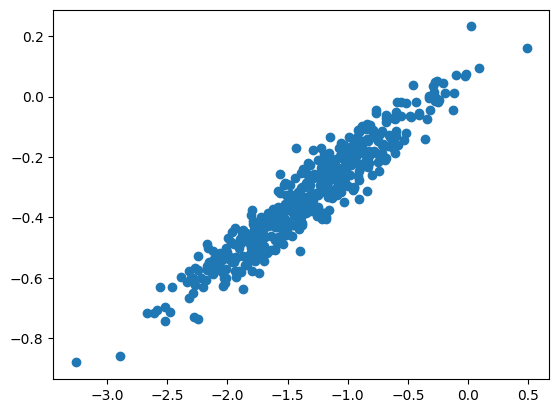

In [24]:
x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
u, s, vh = np.linalg.svd(a)
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


x = x2
y = y2


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)

[[-1.33548573 -0.33179138]] [[[0.2878779  0.08840079]
  [0.08840079 0.03009848]]]
0.958


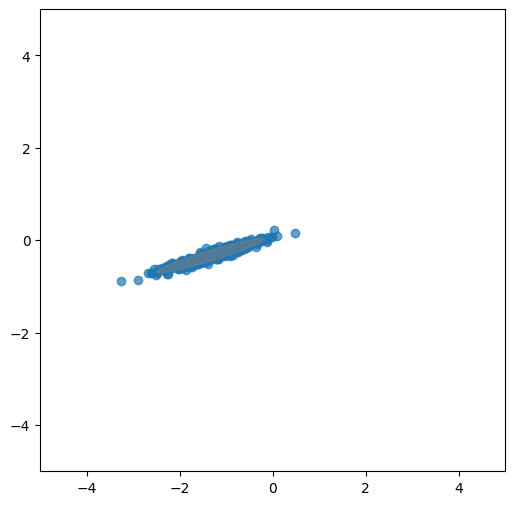

In [25]:
gm = GaussianMixture(n_components=1)
gm.fit(data)
print(gm.means_, gm.covariances_)

patches, coverage = get_patches(gm, 0.9, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


p = patches[0]

print(f"{ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()/data.shape[0]}")


(1500, 2)


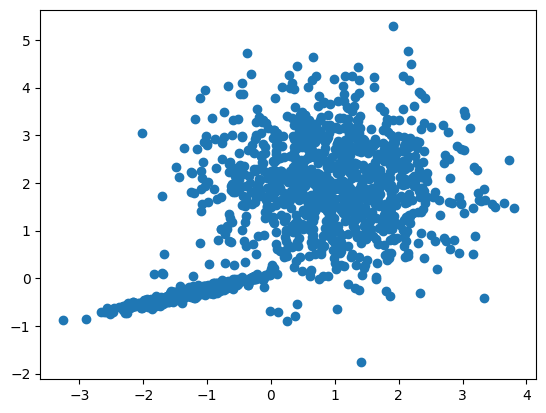

In [26]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



[[-1.33339817 -0.33134205]
 [ 0.94247031  1.99211873]] [[[ 0.28768779  0.08838799]
  [ 0.08838799  0.03011388]]

 [[ 0.94922548 -0.01305215]
  [-0.01305215  0.96661581]]]


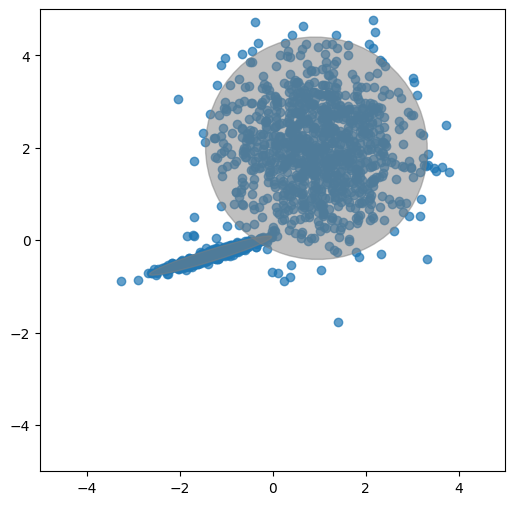

In [27]:
gm = GaussianMixture(n_components=2)
gm.fit(data)
print(gm.means_, gm.covariances_)


# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

In case we have overlap, the "center" gets shifted a bit.  Not sure if this is desirable or not.

[[ 1.67204564  2.44933298]
 [-1.33261001 -0.3310969 ]
 [ 0.21607337  2.30747073]
 [ 1.09161821  1.32065319]]


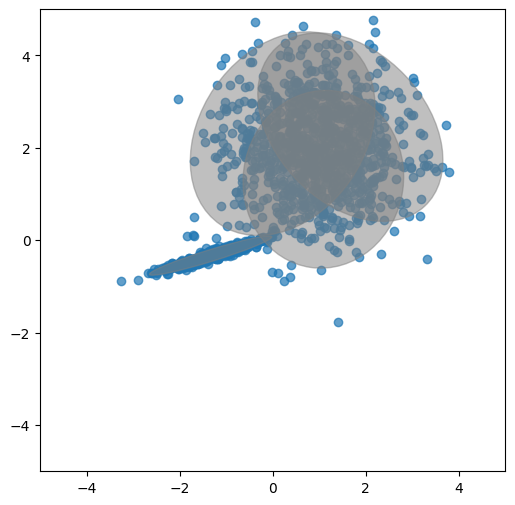

In [49]:
gm = winnow_gm_components(data, confidence_limit=0.95, overlap_allowance=1, cluster_threshold=0.3)
print(gm.means_)

patches, coverage = get_patches(gm, 0.95, data)
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(2, 2)


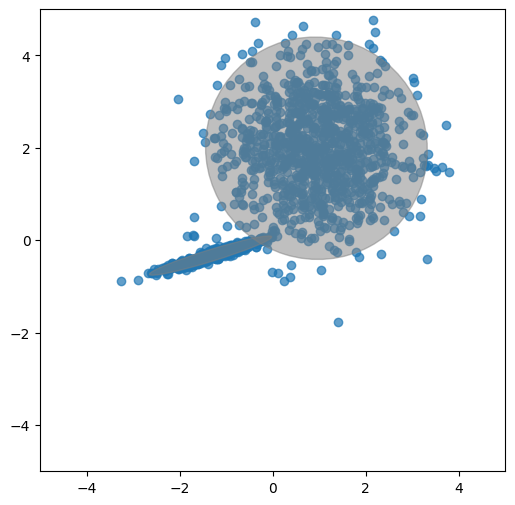

In [47]:
gm = bic_winnow_gm_components(data)


patches, coverage = get_patches(gm, 0.95, data)
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(1500, 2)


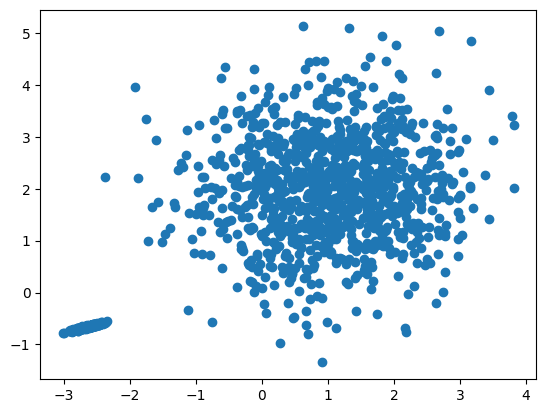

In [13]:
x3 = np.random.normal(loc=-2.0, scale=0.1, size=500)
y3 = np.random.normal(loc=-2.0, scale=0.1, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x3[:, None], y3[:, None]], axis=1) @ a
x3, y3 = v[:,0], v[:,1]


x = np.concatenate([x1, x3])
y = np.concatenate([y1, y3])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



1


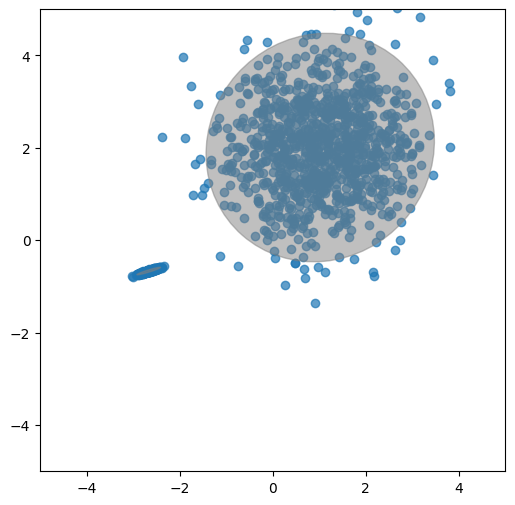

In [14]:
gm = GaussianMixture(n_components=2)
gm.fit(data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

patches, coverage = get_patches(gm, 0.95, data)

plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


gm = winnow_gm_components(data)
print(gm.means_.shape[0])

### Dumb bug

Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True


False


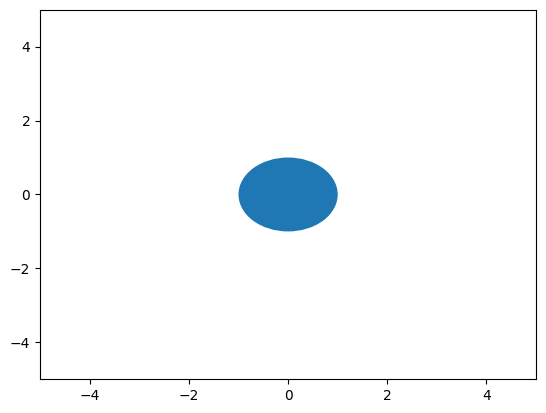

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

### Test on 3D

In [16]:
x = np.random.normal(loc=1.0, scale=1.0, size=1000)
y = np.random.normal(loc=2.0, scale=1.0, size=1000)
z = np.random.normal(loc=3.0, scale=2.0, size=1000)


data = np.stack([x, y, z], axis=1)
print(data.shape)


(1000, 3)


0.959
0.945


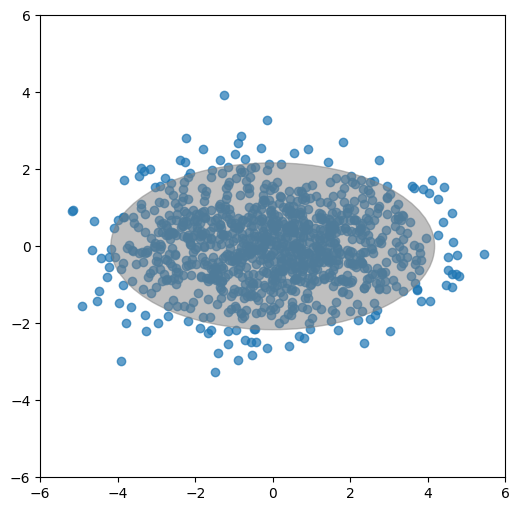

In [17]:
from sklearn.decomposition import PCA

gm = GaussianMixture(n_components=1)
gm.fit(data)

pca = PCA(n_components=2)
pca.fit(data)
red_data = pca.transform(data)


patches, _ = get_patches(gm, confidence=0.9, pts=data, pca=pca)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])


plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
for p in patches:
    ax.add_patch(p)


p = patches[0]


print(f"{ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()/data.shape[0]}")
print(f"{ellipse_contains_points((gm.means_[0] - pca.mean_) @ pca.components_.T, pca.components_ @ gm.covariances_[0] @ pca.components_.T, red_data).sum()/data.shape[0]}")
